conda install -c conda-forge openff-interchange lammps

In [ ]:
from openff.interchange import Interchange
from openff.toolkit import ForceField, Molecule
from rdkit import Chem
from rdkit.Chem import AllChem

In [17]:
smiles = "CC(=O)O"
mol = Chem.MolFromSmiles(smiles)
mol = AllChem.AddHs(mol)

In [18]:
off_mol = Molecule.from_rdkit(mol)
off_mol.generate_conformers()

ff = ForceField("openff-2.0.0.offxml")
interchange = Interchange.from_smirnoff(topology=[off_mol], force_field=ff)

In [34]:
interchange.to_lammps_datafile("acetic_acid.data")

In [88]:
lmp_input = """
units real
atom_style full

dimension 3
boundary p p p

bond_style hybrid harmonic
angle_style hybrid harmonic
dihedral_style hybrid fourier
improper_style cvff
special_bonds lj 0.0 0.0 0.5 coul 0.0 0.0 0.8333333333 
pair_style lj/cut/coul/cut 12.0 12.0
pair_modify mix arithmetic tail yes

read_data acetic_acid.data

compute DIPOLE all dipole
thermo_style custom step time ebond eangle edihed eimp epair evdwl ecoul elong etail pe c_DIPOLE[0] c_DIPOLE[1] c_DIPOLE[2]
timestep 1.0
fix NVT all nvt temp 300.0 300.0 100.0
thermo 1000
run 1000000

"""

with open("dipole.in", "w") as fi:
    fi.write(lmp_input)

In [89]:
!lmp_mpi -i dipole.in -log dipole.log

LAMMPS (29 Aug 2024)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  triclinic box = (-1.5976414 -0.92598225 -0.59568708) to (98.402359 99.074018 99.404313) with tilt (0 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  8 atoms
  scanning bonds ...
  4 = max bonds/atom
  scanning angles ...
  6 = max angles/atom
  scanning dihedrals ...
  15 = max dihedrals/atom
  scanning impropers ...
  3 = max impropers/atom
  triclinic box = (-1.5976414 -0.92598225 -0.59568708) to (98.402359 99.074018 99.404313) with tilt (0 0 0)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  7 bonds
  reading angles ...
  10 angles
  reading dihedrals ...
  15 dihedrals
  reading impropers ...
  3 impropers
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0.5     
  special bond factors coul:  0        0        0.8333333333
     4 = max # of 1-2 neighbors
     4 = max

In [ ]:
import pandas as pd

with open("dipole.log") as fi:
    lines = fi.readlines()
    for i, line in enumerate(lines):
        if "Per MPI rank " in line:
            begin = i + 1
        elif "Loop time of" in line:
            end = i - 1

df = pd.read_csv("dipole.log", skiprows=begin, nrows=end - begin, delim_whitespace=True)

/tmp/ipykernel_1782/461179216.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("dipole.log", skiprows=begin, nrows=end-begin, delim_whitespace=True)


In [ ]:
df["DIPOLE_total"] = (
    df["c_DIPOLE[0]"] ** 2 + df["c_DIPOLE[1]"] ** 2 + df["c_DIPOLE[2]"] ** 2
) ** 0.5

Text(0.5, 1.0, 'Total dipole 0.47 e*A')

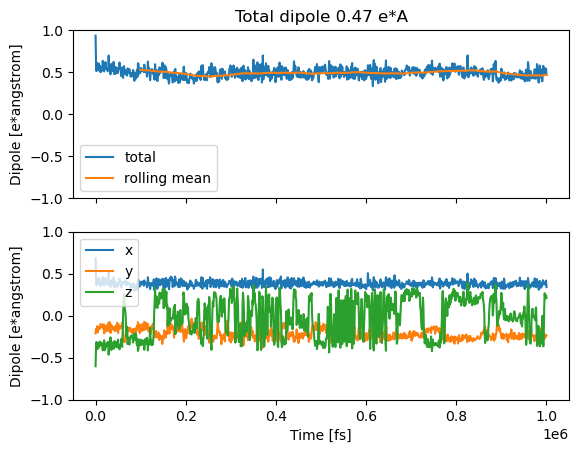

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
for i, axis in enumerate(["x", "y", "z"]):
    ax[1].plot(df["Time"], df[f"c_DIPOLE[{i}]"], label=axis)
ax[0].plot(df["Time"], df["DIPOLE_total"], label="total")
ax[0].plot(df["Time"], df["DIPOLE_total"].rolling(100).mean(), label="rolling mean")

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel("Time [fs]")
    ax[i].set_ylabel("Dipole [e*angstrom]")
    ax[i].set_ylim(-1, 1)
    ax[i].label_outer()

dipole_mean = df["DIPOLE_total"][-100:].mean()
ax[0].set_title(f"Total dipole {dipole_mean:.2f} e*A")